# Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).


In [215]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [216]:
with open('ultimate_data_challenge.json') as d:
    data= json.load(d)

data= pd.DataFrame(data)

In [217]:
data.shape

(50000, 12)

In [218]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [219]:
data.columns

Index(['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge',
       'city', 'last_trip_date', 'phone', 'signup_date', 'surge_pct',
       'trips_in_first_30_days', 'ultimate_black_user', 'weekday_pct'],
      dtype='object')

In [220]:
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


In [221]:
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


We need to convert Signup_data and last_trip_date to datatime format since they are currently stored as string objects

In [222]:
data.last_trip_date = pd.to_datetime(data.last_trip_date)
data.signup_date=pd.to_datetime(data.signup_date)

In [223]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null datetime64[ns]
phone                     49604 non-null object
signup_date               50000 non-null datetime64[ns]
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), datetime64[ns](2), float64(6), int64(1), object(2)
memory usage: 4.2+ MB


In [224]:
data.last_trip_date.describe()

count                   50000
unique                    182
top       2014-06-29 00:00:00
freq                     2036
first     2014-01-01 00:00:00
last      2014-07-01 00:00:00
Name: last_trip_date, dtype: object

Let us create a field trips_in_last_30_days. This is a boolean field with 1 for a trip in last 30 days(active) or 0 for no trip in last 30days (inactive)

In [225]:
data['trips_in_last_30_days'] = (data.last_trip_date >= '2014-06-01')*1
data['trips_in_last_30_days']

0        1
1        0
2        0
3        1
4        0
5        1
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       1
14       0
15       0
16       1
17       1
18       1
19       1
20       0
21       0
22       0
23       1
24       0
25       0
26       0
27       0
28       1
29       0
        ..
49970    0
49971    1
49972    1
49973    1
49974    0
49975    1
49976    1
49977    0
49978    0
49979    0
49980    0
49981    0
49982    0
49983    0
49984    0
49985    0
49986    0
49987    0
49988    1
49989    0
49990    0
49991    1
49992    0
49993    1
49994    0
49995    1
49996    0
49997    0
49998    0
49999    0
Name: trips_in_last_30_days, Length: 50000, dtype: int64

Let us calculate the rate of retention of users. i.e the active users.


In [226]:
active_users = data['trips_in_last_30_days'].sum()/data['trips_in_last_30_days'].count() * 100
active_users

37.608000000000004

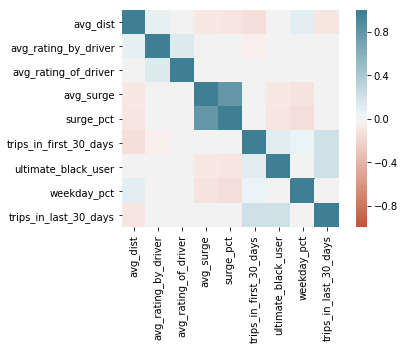

In [227]:
import seaborn as sns
corr = data.corr()
sns.heatmap(corr,vmin=-1,vmax=1,center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

In [228]:
corr['trips_in_last_30_days'].sort_values(ascending=False)

trips_in_last_30_days     1.000000
trips_in_first_30_days    0.210463
ultimate_black_user       0.205002
surge_pct                 0.011797
weekday_pct               0.009693
avg_surge                -0.003333
avg_rating_of_driver     -0.011653
avg_rating_by_driver     -0.026791
avg_dist                 -0.092780
Name: trips_in_last_30_days, dtype: float64

As we can see from the correlation map above, the trips_is_last_30_days is mostly correlated to trips_in_first_30_days and ultimate_black_user.




Now let us convert the datetime objects to integers. 
For data['signup_date'], we can convert this into an integer by subtracting the date from july 1st which is frame of reference date.

In [229]:
data['last_trip_date'].isnull().sum()/data['last_trip_date'].isnull().count()

0.0

In [230]:
data['signup_date']= data['signup_date'] - min(data['signup_date'])
data['signup_date'] = data['signup_date'].dt.days.astype('int16')
data['signup_date'].head(5)

0    24
1    28
2     5
3     9
4    26
Name: signup_date, dtype: int16

For data['last_trip_date'], we can convert this to an interger by subtracting this date from 1st july which.

In [231]:
data['last_trip_date']= max(data['last_trip_date']) - data['last_trip_date']
data['last_trip_date']= data['last_trip_date'].dt.days.astype('int16')
data['last_trip_date'].head()

0     14
1     57
2    175
3      2
4    108
Name: last_trip_date, dtype: int16

Since these above two fields are continous variables, it is better to bin these variables. 

In [232]:
data['signup_date']=pd.cut(data['signup_date'],bins=8,labels=False)
data['last_trip_date'] = pd.cut(data['last_trip_date'], bins=8, labels=False)

In [233]:
data['ultimate_black_user'] = data['ultimate_black_user']*1

Now, let us make the non numeric columns, phone and city numeric by one ht encoding.

In [234]:
data.phone.isnull().sum()/data.phone.isnull().count()

0.00792

In [235]:
data.city.isnull().sum()/data.city.isnull().count()

0.0

In [236]:
data.phone.value_counts()

iPhone     34582
Android    15022
Name: phone, dtype: int64

Since there are a few missing values in phone field, lets fill them up with value 'other'.

In [237]:
data.phone.fillna('other',inplace=True)

In [238]:
data.city.isnull().sum()/data.city.isnull().count()

0.0

Now let us see if we have any missing values.

In [239]:
data.isnull().sum()/data.isnull().count()

avg_dist                  0.00000
avg_rating_by_driver      0.00402
avg_rating_of_driver      0.16244
avg_surge                 0.00000
city                      0.00000
last_trip_date            0.00000
phone                     0.00000
signup_date               0.00000
surge_pct                 0.00000
trips_in_first_30_days    0.00000
ultimate_black_user       0.00000
weekday_pct               0.00000
trips_in_last_30_days     0.00000
dtype: float64

data['avg_rating_of_driver'] has around 16% of missing values and data['avg_rating_by_driver'] has around 0.4% missing vlaues. Lets fill this with 0.

In [240]:
data['avg_rating_of_driver'].fillna(0,inplace=True)
data['avg_rating_by_driver'].fillna(0,inplace=True)
data.isnull().sum()/data.isnull().count()

avg_dist                  0.0
avg_rating_by_driver      0.0
avg_rating_of_driver      0.0
avg_surge                 0.0
city                      0.0
last_trip_date            0.0
phone                     0.0
signup_date               0.0
surge_pct                 0.0
trips_in_first_30_days    0.0
ultimate_black_user       0.0
weekday_pct               0.0
trips_in_last_30_days     0.0
dtype: float64

Also, let us seperate data['trips_in_last_30_days'] from the dataframe.

Let convert  two fields - city and phone to numeric with onehot encoding

In [244]:
from sklearn.preprocessing import LabelEncoder
labelenc = LabelEncoder()
data['phone']=labelenc.fit_transform(data['phone'])
data['city']=labelenc.fit_transform(data['city'])
data.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,trips_in_last_30_days
0,3.67,5.0,4.7,1.10,1,0,1,6,15.4,4,1,46.2,1
1,8.26,5.0,5.0,1.00,0,2,0,7,0.0,0,0,50.0,0
2,0.77,5.0,4.3,1.00,0,7,1,1,0.0,3,0,100.0,0
3,2.36,4.9,4.6,1.14,1,0,1,2,20.0,9,1,80.0,1
4,3.13,4.9,4.4,1.19,2,4,0,6,11.8,14,0,82.4,0


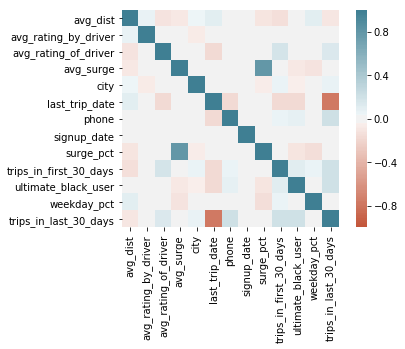

In [245]:
corr = data.corr()
sns.heatmap(corr,vmin=-1,vmax=1,center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)

In [246]:
from sklearn.preprocessing import OneHotEncoder

onehotencoder=OneHotEncoder(categorical_features =[4,5,6,7])
data=onehotencoder.fit_transform(data).toarray()
data = pd.DataFrame(data)
data.head()

/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:392: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,3.67,5.0,4.7,1.10,15.4,4.0,1.0,46.2,1.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,8.26,5.0,5.0,1.00,0.0,0.0,0.0,50.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.77,5.0,4.3,1.00,0.0,3.0,0.0,100.0,0.0
3,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.36,4.9,4.6,1.14,20.0,9.0,1.0,80.0,1.0
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,3.13,4.9,4.4,1.19,11.8,14.0,0.0,82.4,0.0


In [248]:
Y = data[30]
data.drop([30],axis=1,inplace=True)

We are now ready for the modelling.

### Part 2 

Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

The Main steps involded in modelling are:
    1. Create train and test sets
    2. Instantiate and try few models and select a model which has the best performance
    3. Specify the hyper paramter space
    4. Instantiate GridSearchCV or RandomizedSearchCV objects
    5. Fit object to the training set
    6. Predict the test set
    7. Compute the scores and analyze the results.

In [249]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(data,Y, test_size=0.3)


### Logistic Regression

In [250]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,confusion_matrix, classification_report
logreg= LogisticRegression()
logreg.fit(X_train,y_train)
y_pred=logreg.predict_proba(X_test)[:,1]
roc_auc_scor= roc_auc_score(y_test,y_pred)
print('\nClassification report: \n',classification_report(y_test, logreg.predict(X_test)))
print("roc_auc_score is ",roc_auc_scor)

/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      9340
         1.0       0.97      0.92      0.94      5660

   micro avg       0.96      0.96      0.96     15000
   macro avg       0.96      0.95      0.95     15000
weighted avg       0.96      0.96      0.96     15000

roc_auc_score is  0.9945636004570183


### Random Forest Classifier

In [251]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rfc.fit(X_train,y_train)
y_pred=rfc.predict_proba(X_test)[:,1]
roc_auc_scor= roc_auc_score(y_test,y_pred)
print('\nClassification report: \n',classification_report(y_test, rfc.predict(X_test)))
print("roc_auc_score is ",roc_auc_scor)


Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.96      9340
         1.0       0.96      0.92      0.94      5660

   micro avg       0.95      0.95      0.95     15000
   macro avg       0.95      0.95      0.95     15000
weighted avg       0.95      0.95      0.95     15000

roc_auc_score is  0.9941356943425066


### Xgboost Classifier

In [252]:
from xgboost import XGBClassifier
xgb = XGBClassifier()
xgb.fit(X_train,y_train)
y_pred=xgb.predict_proba(X_test)[:,1]
roc_auc_scor= roc_auc_score(y_test,y_pred)
print('\nClassification report: \n',classification_report(y_test, xgb.predict(X_test)))
print("roc_auc_score is ",roc_auc_scor)


Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      9340
         1.0       0.97      0.92      0.94      5660

   micro avg       0.96      0.96      0.96     15000
   macro avg       0.96      0.95      0.96     15000
weighted avg       0.96      0.96      0.96     15000

roc_auc_score is  0.9947572752173486


From the above results it is evident that XGBoost classifier performs the best with ROC area under the cure=99.5%. We continue with the hyperparameter tuning to find optimal paramters for better results.

### Hyper Parameter Tuning

In [255]:
from sklearn.model_selection import GridSearchCV
param_grid={
        'gamma': [0,0.5, 1],
        'subsample': [0.6, 0.8,1],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [4,5,6],
        'base_score': [0.5,0.6]
        }

xgb2 = XGBClassifier()
clf=GridSearchCV(estimator=xgb2,param_grid=param_grid)
clf.fit(X_train,y_train)

/Users/deepikasridhar/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'gamma': [0, 0.5, 1], 'subsample': [0.6, 0.8, 1], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [4, 5, 6], 'base_score': [0.5, 0.6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [257]:
clf.best_params_

{'base_score': 0.6,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'max_depth': 4,
 'subsample': 1}

We can now use these parameters in our algorithm and see if we can improve the score of our model.

In [259]:
from xgboost import XGBClassifier
xgb = XGBClassifier(base_score=0.6,
 colsample_bytree= 0.8,
 gamma= 0,
 max_depth= 4,
 subsample= 1)
xgb.fit(X_train,y_train)
y_pred=xgb.predict_proba(X_test)[:,1]
roc_auc_scor= roc_auc_score(y_test,y_pred)
print('\nClassification report: \n',classification_report(y_test, xgb.predict(X_test)))
print("roc_auc_score is ",roc_auc_scor)


Classification report: 
               precision    recall  f1-score   support

         0.0       0.95      0.98      0.97      9340
         1.0       0.97      0.92      0.94      5660

   micro avg       0.96      0.96      0.96     15000
   macro avg       0.96      0.95      0.96     15000
weighted avg       0.96      0.96      0.96     15000

roc_auc_score is  0.994777175187839


The optimal parameters have slightly increased our model efficiency. Let us examine our model score further.

#### confusion_matrix

In [261]:
confusion_matrix(y_test, xgb.fit(X_train,y_train).predict(X_test))

array([[9189,  151],
       [ 470, 5190]])

The first row is about not retained passengers, so our algorithm classified 9189 people as not retained correctly and 151 people incorrectly.

The model classified 5190 people as retained correctly and 470 people as retained incorrectly.

#### Precision Recall Curve 

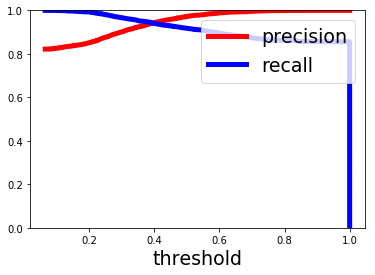

<Figure size 1008x504 with 0 Axes>

In [264]:
from sklearn.metrics import precision_recall_curve
from inspect import signature
precision,recall,threshold = precision_recall_curve(y_test,y_pred)
plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
plt.xlabel("threshold", fontsize=19)
plt.legend(loc="upper right", fontsize=19)
plt.ylim([0, 1])
plt.figure(figsize=(14, 7))
plt.show()

The model has a high precision recall tradeoff of almost 1.

## Conclusion

The best ways to improve retention of passengers are:
    1. Signing up users for ultimate black program
    2. Increase rider incentives for recent riders so they keep coming back
    3. Increase rider engagement with rating the drivers 
    